In [4]:
import pandas as pd
import mne
import torch
import numpy as np

In [5]:
def extract_vo2_data(file_path, start_row=147, time_col='J', vo2_col='K'):
    df = pd.read_excel(file_path, skiprows=147)

    time = df.iloc[:, 9].tolist()
    vo2 = df.iloc[:, 10].tolist()
    return pd.DataFrame({'Time': time, 'VO2': vo2})

vo2_df = extract_vo2_data(r"D:\UCF\Brain Lab\EEG Data\Pilot4_data\Metabolics\pilot4Oct_OG_A.xlsx")
vo2_df['Time'] = pd.TimedeltaIndex(vo2_df['Time'].astype("str")).total_seconds()

vo2_np = vo2_df.to_numpy()
print(vo2_df)

      Time    VO2
0      1.0   9.81
1      3.0   7.37
2      6.0   7.06
3      8.0   5.83
4     10.0   5.23
..     ...    ...
135  273.0  19.52
136  277.0  14.89
137  279.0  13.07
138  291.0  17.34
139  293.0  20.49

[140 rows x 2 columns]


In [6]:
def read_bdf_file(file_path):
    raw = mne.io.read_raw_bdf(file_path, preload=True)
    return raw

raw_data  = read_bdf_file(r"D:\UCF\Brain Lab\EEG Data\Pilot4_data\EEG\Pilot4Oct_OG_A.bdf")
raw_data.times[-1]

Extracting EDF parameters from D:\UCF\Brain Lab\EEG Data\Pilot4_data\EEG\Pilot4Oct_OG_A.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 155135  =      0.000 ...   302.998 secs...


302.998046875

In [7]:
sampling_frequecy = raw_data.info['sfreq']
samples_to_trim = int(10*sampling_frequecy)

# trim last 10 seconds
raw_data_trimmed = raw_data.copy().crop(tmax=raw_data.times[-samples_to_trim - 1])
print(f"New duration: {raw_data_trimmed.times[-1]} seconds")

raw_data_trimmed.get_data().shape

New duration: 292.998046875 seconds


(144, 150016)

In [8]:
def interpolate_vo2_data(vo2_df):    
    vo2_df = vo2_df.copy()
    # Convert the 'Time' column to a datetime format
    vo2_df['Time'] = pd.to_datetime(vo2_df['Time'], unit='s')

    # Set the 'Time' column as the index
    vo2_df.set_index('Time', inplace=True)
    
    # Resample the data to a frequency of 1 second and interpolate missing values
    vo2_df = vo2_df.resample('1S').interpolate(method='polynomial', order=3)
    
    # Reset the index to get 'Time' back as a column
    vo2_df.reset_index(inplace=True)
    
    # Convert 'Time' back to seconds
    vo2_df['Time'] = vo2_df['Time'].dt.second
    
    return vo2_df

# Interpolate the VO2 data
vo2_df_interpolated = interpolate_vo2_data(vo2_df)
vo2_df_interpolated

C:\Users\mamoo\AppData\Local\Temp\ipykernel_25636\1174760391.py:10: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  vo2_df = vo2_df.resample('1S').interpolate(method='polynomial', order=3)


,Time,VO2
0,1,9.810000
1,2,8.157491
2,3,7.370000
3,4,7.133764
4,5,7.135018
...,...,...
288,49,14.872675
289,50,16.020479
290,51,17.340000
291,52,18.830190


In [12]:
def align_vo2_with_eeg(vo2_df, eeg_raw):
    # Calculate the number of EEG samples per second
    sfreq = eeg_raw.info['sfreq']
    samples_per_second = int(sfreq)

    eeg_data = eeg_raw.get_data()
    X = []
    y = []

    for i in range(len(vo2_df)):
        start_time = vo2_df['Time'].iloc[i]
        start_sample = int(start_time * sfreq)
        end_sample = start_sample + samples_per_second

        if end_sample > eeg_data.shape[1]:
            break

        eeg_segment = eeg_data[:, start_sample:end_sample]
        vo2_value = vo2_df['VO2'].iloc[i]

        X.append(eeg_segment)
        y.append(vo2_value)

    X = np.array(X)
    y = np.array(y)

    return X, y, eeg_data

# Assuming vo2_df_interpolated is the interpolated VO2 data
X, y, eeg_data = align_vo2_with_eeg(vo2_df_interpolated, raw_data)

In [8]:
import torch
from torch import nn
from torch.nn import MaxPool1d

class MODCNN_1D_MUST(nn.Module):
    def __init__(self, numChannels, numNodes=[128, 128, 128, 64, 256]):
        """
        :param numChannels:
        :param classes:
        :param numNodes: number of nodes in hidden layer
        Structure of CNN: CONV1 => RELU => CONV2 => RELU => POOLING => DROPOUT
        """
        # Call the parent constructor
        super(MODCNN_1D_MUST, self).__init__()
        # self.classes = classes
        self.channels = numChannels

        conv1 = torch.nn.Conv1d(in_channels=numChannels, out_channels=numNodes[0], kernel_size=3)
        relu1 = torch.nn.ReLU()
        conv2 = torch.nn.Conv1d(in_channels=numNodes[0], out_channels=numNodes[1], kernel_size=3)
        relu2 = torch.nn.ReLU()
        maxpool2 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        dropout2 = nn.Dropout(p=0.5)
        self.cnnBlock1 = nn.Sequential(conv1, relu1, conv2, relu2, maxpool2, dropout2)

        # initialize second set of CNN
        conv3 = torch.nn.Conv1d(in_channels=numNodes[1], out_channels=numNodes[2], kernel_size=3)
        relu3 = torch.nn.ReLU()
        conv4 = torch.nn.Conv1d(in_channels=numNodes[2], out_channels=numNodes[3], kernel_size=3)
        relu4 = torch.nn.ReLU()
        maxpool4 = MaxPool1d(kernel_size=2, stride=2)
        dropout4 = nn.Dropout(p=0.5)
        self.cnnBlock2 = nn.Sequential(conv3, relu3, conv4, relu4, maxpool4, dropout4)

        # Calculate the size of the flattened feature map
        self._to_linear = None
        self.convs(torch.randn(1, numChannels, 512))

        # Regression output
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._to_linear, numNodes[4]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(numNodes[4], 1)
        )

    def convs(self, x):
        x = self.cnnBlock1(x)
        x = self.cnnBlock2(x)
        if self._to_linear is None:
            self._to_linear = x.shape[1] * x.shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = self.regressor(x)
        return x


In [9]:
from NMI.nmi_1d_v2 import Trainer1DCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

channels = raw_data.get_data().shape[0]


model = MODCNN_1D_MUST(numChannels=channels, numNodes=[128, 128, 128, 64, 256])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()


trainer = Trainer1DCNN(device=device, model=model, x_data=X, y_data=y, optimizer=optimizer, criterion=criterion)

model_ret, trained_model = trainer(epoches=500)


Number of train batch: 4; train batch size is: 64
Number of val batch: 1; val batch size is: 64
Epoch 1/500, Training Loss: 4255134.1250, Validation Loss: 270.0937, MAE: 15.9887, MSE: 270.0937
Epoch 2/500, Training Loss: 16942.8379, Validation Loss: 1742.3298, MAE: 41.5601, MSE: 1742.3298
Epoch 3/500, Training Loss: 2337.6661, Validation Loss: 267.2409, MAE: 15.9025, MSE: 267.2409
Epoch 4/500, Training Loss: 497.3994, Validation Loss: 267.2351, MAE: 15.9023, MSE: 267.2351
Epoch 5/500, Training Loss: 277.1268, Validation Loss: 267.2249, MAE: 15.9019, MSE: 267.2249
Epoch 6/500, Training Loss: 266.4797, Validation Loss: 267.2092, MAE: 15.9015, MSE: 267.2092
Epoch 7/500, Training Loss: 246.4984, Validation Loss: 267.1898, MAE: 15.9008, MSE: 267.1897
Epoch 8/500, Training Loss: 164.0550, Validation Loss: 267.1692, MAE: 15.9002, MSE: 267.1692
Epoch 9/500, Training Loss: 183.5320, Validation Loss: 267.1569, MAE: 15.8998, MSE: 267.1569
Epoch 10/500, Training Loss: 187.7555, Validation Loss: 26

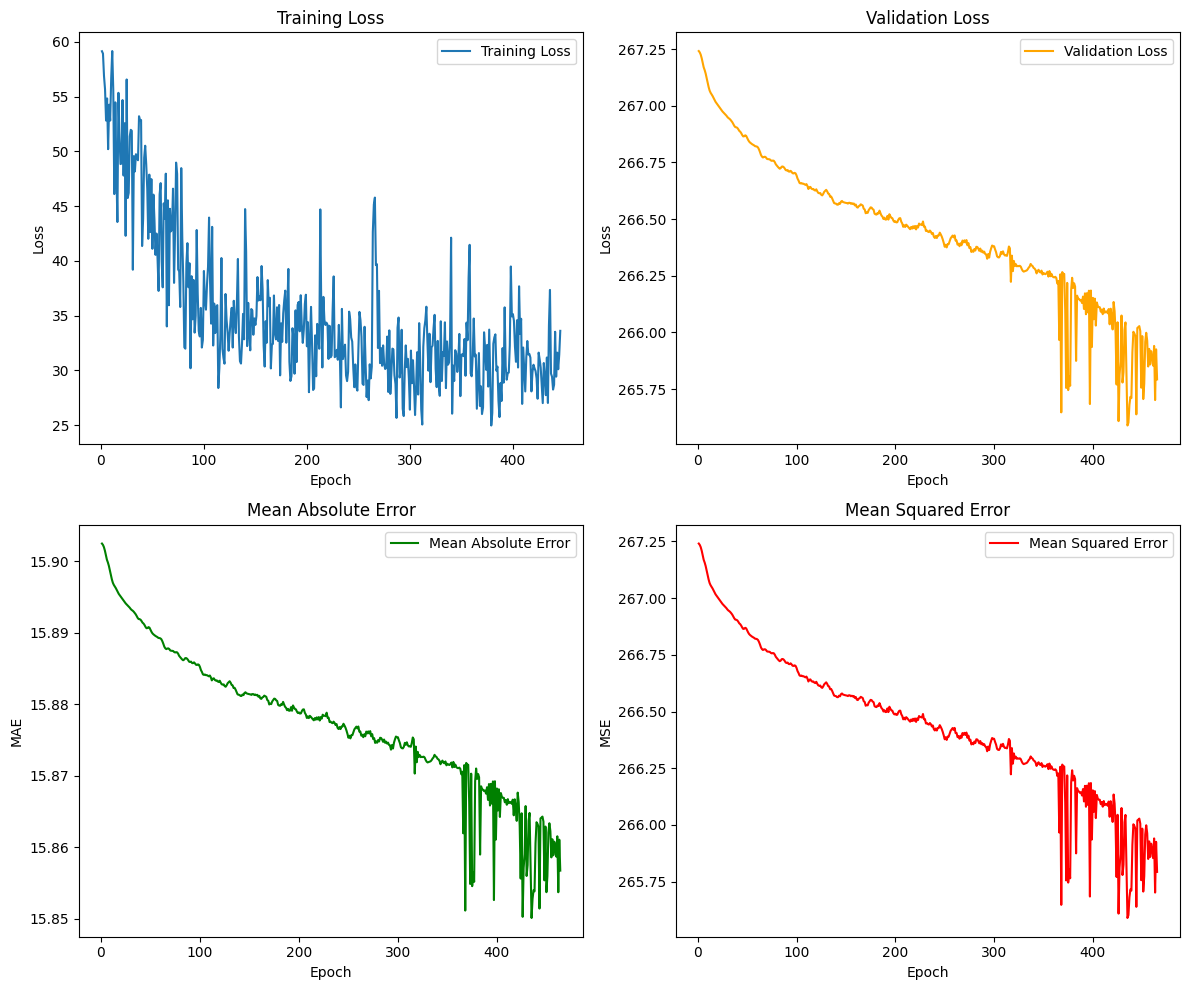

In [10]:
import matplotlib.pyplot as plt

def remove_outliers(data):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    return filtered_data

def plot_metrics(model_ret):
    epochs = model_ret['epoch']
    
    # Remove outliers from each metric
    train_loss = remove_outliers(model_ret['train_loss'])
    val_loss = remove_outliers(model_ret['val_loss'])
    mae = remove_outliers(model_ret['mae'])
    mse = remove_outliers(model_ret['mse'])
    
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot training loss
    axs[0, 0].plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
    axs[0, 0].set_title('Training Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    
    # Plot validation loss
    axs[0, 1].plot(epochs[:len(val_loss)], val_loss, label='Validation Loss', color='orange')
    axs[0, 1].set_title('Validation Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()
    
    # Plot MAE
    axs[1, 0].plot(epochs[:len(mae)], mae, label='Mean Absolute Error', color='green')
    axs[1, 0].set_title('Mean Absolute Error')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('MAE')
    axs[1, 0].legend()
    
    # Plot MSE
    axs[1, 1].plot(epochs[:len(mse)], mse, label='Mean Squared Error', color='red')
    axs[1, 1].set_title('Mean Squared Error')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('MSE')
    axs[1, 1].legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_metrics(model_ret)